## Introducción a (Py)OpenCL

Para tener pyopencl es necesario tener numpy, boost c++, opencl y python.

### Arquitectura abstracta en OpenCL

imagenes de http://mathema.tician.de/software/pyopencl/


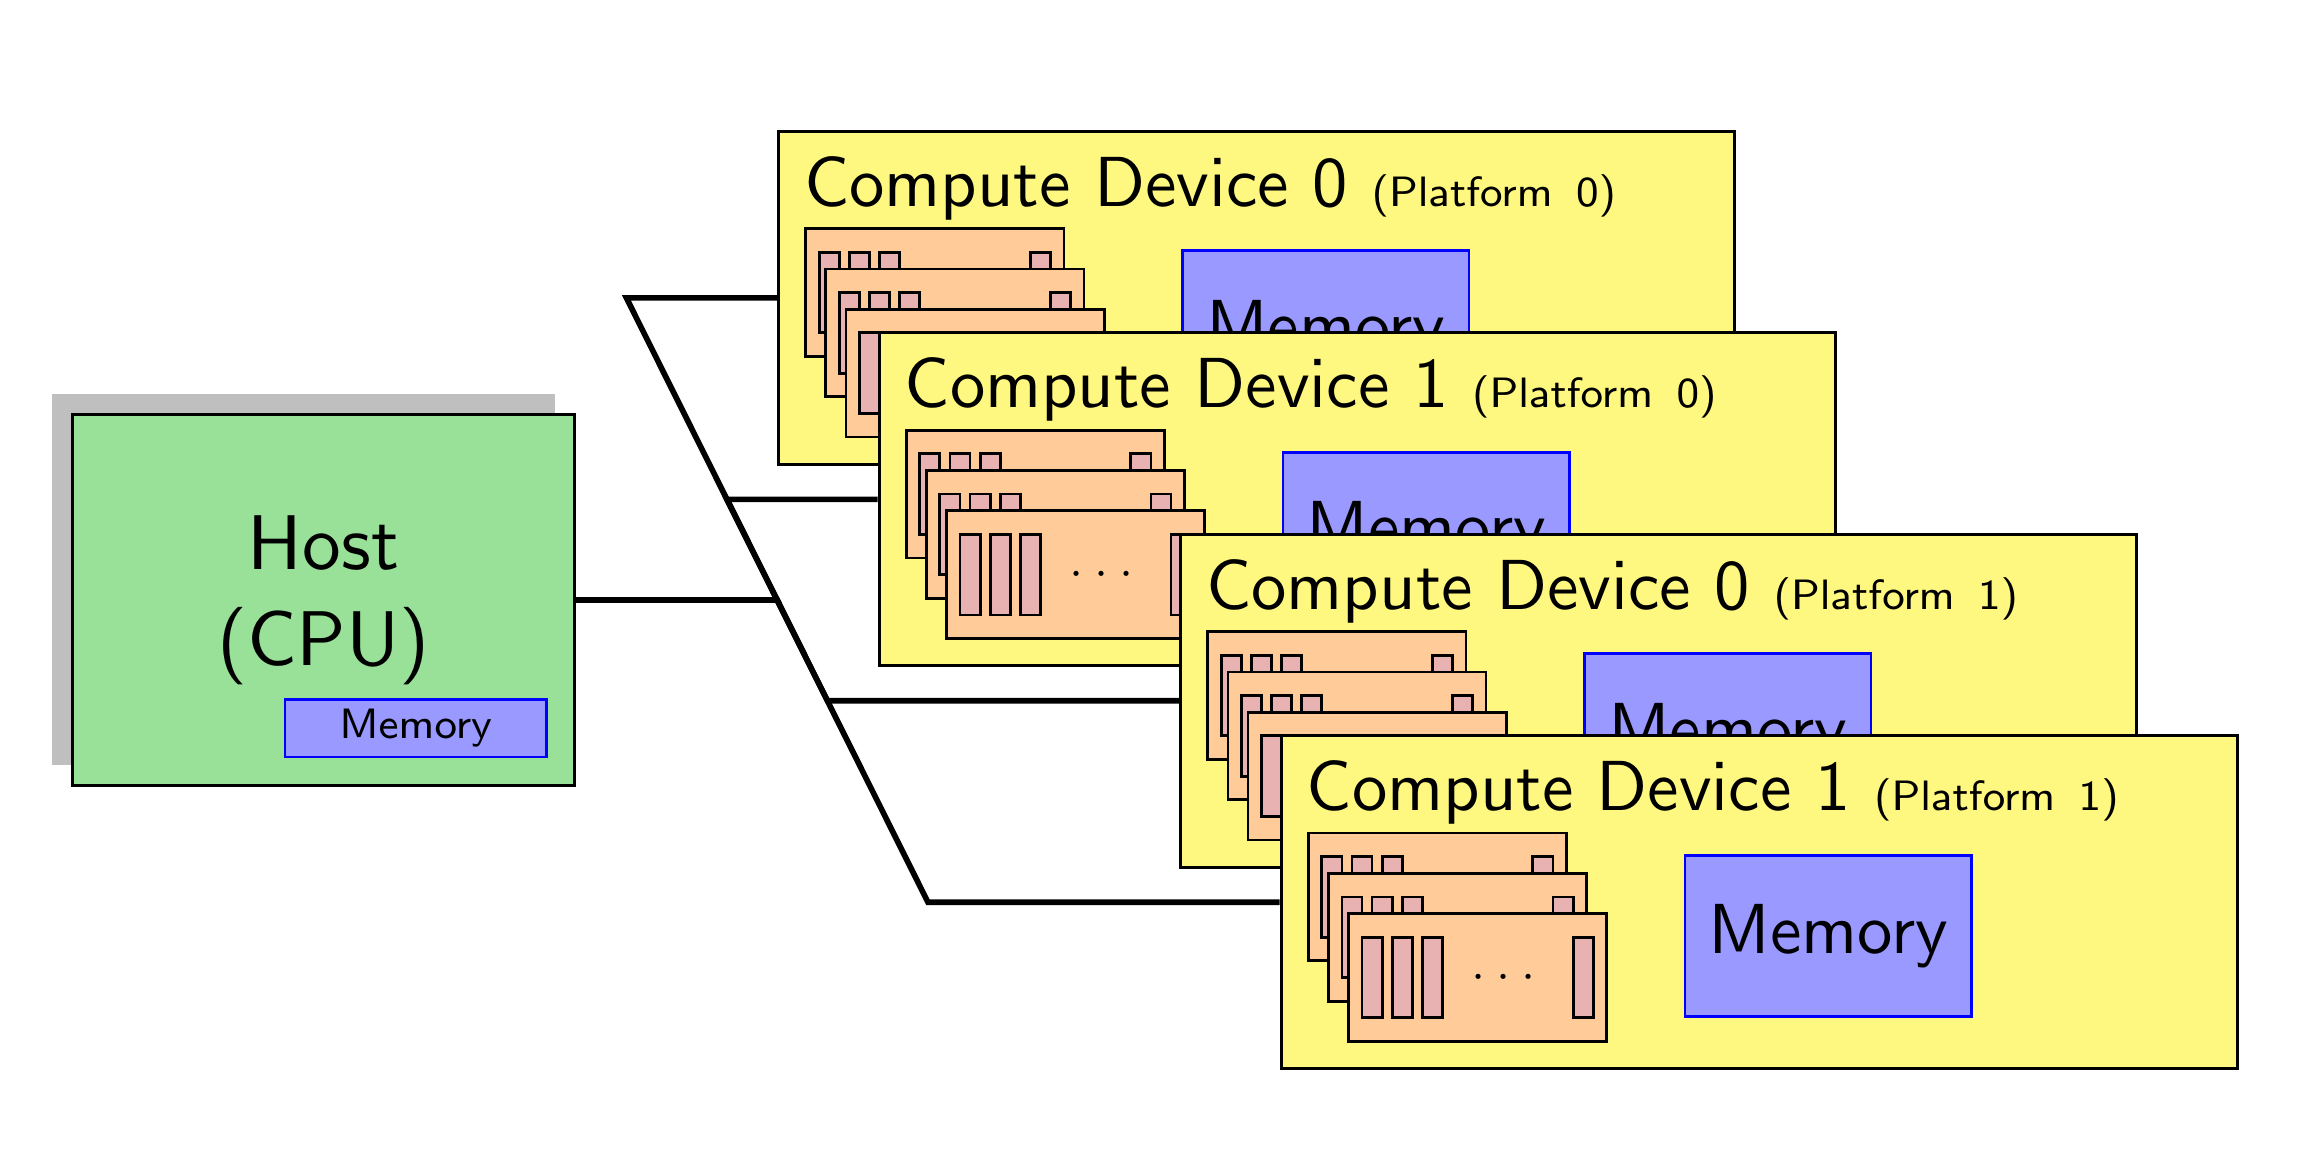

In [40]:
from IPython.display import Image
print "imagenes de http://mathema.tician.de/software/pyopencl/"
Image(filename='Capturas/schema.png', width=500)


### Tipos de memoria en OpenCL

imagenes de Heterogeneous Computing with OpenCL


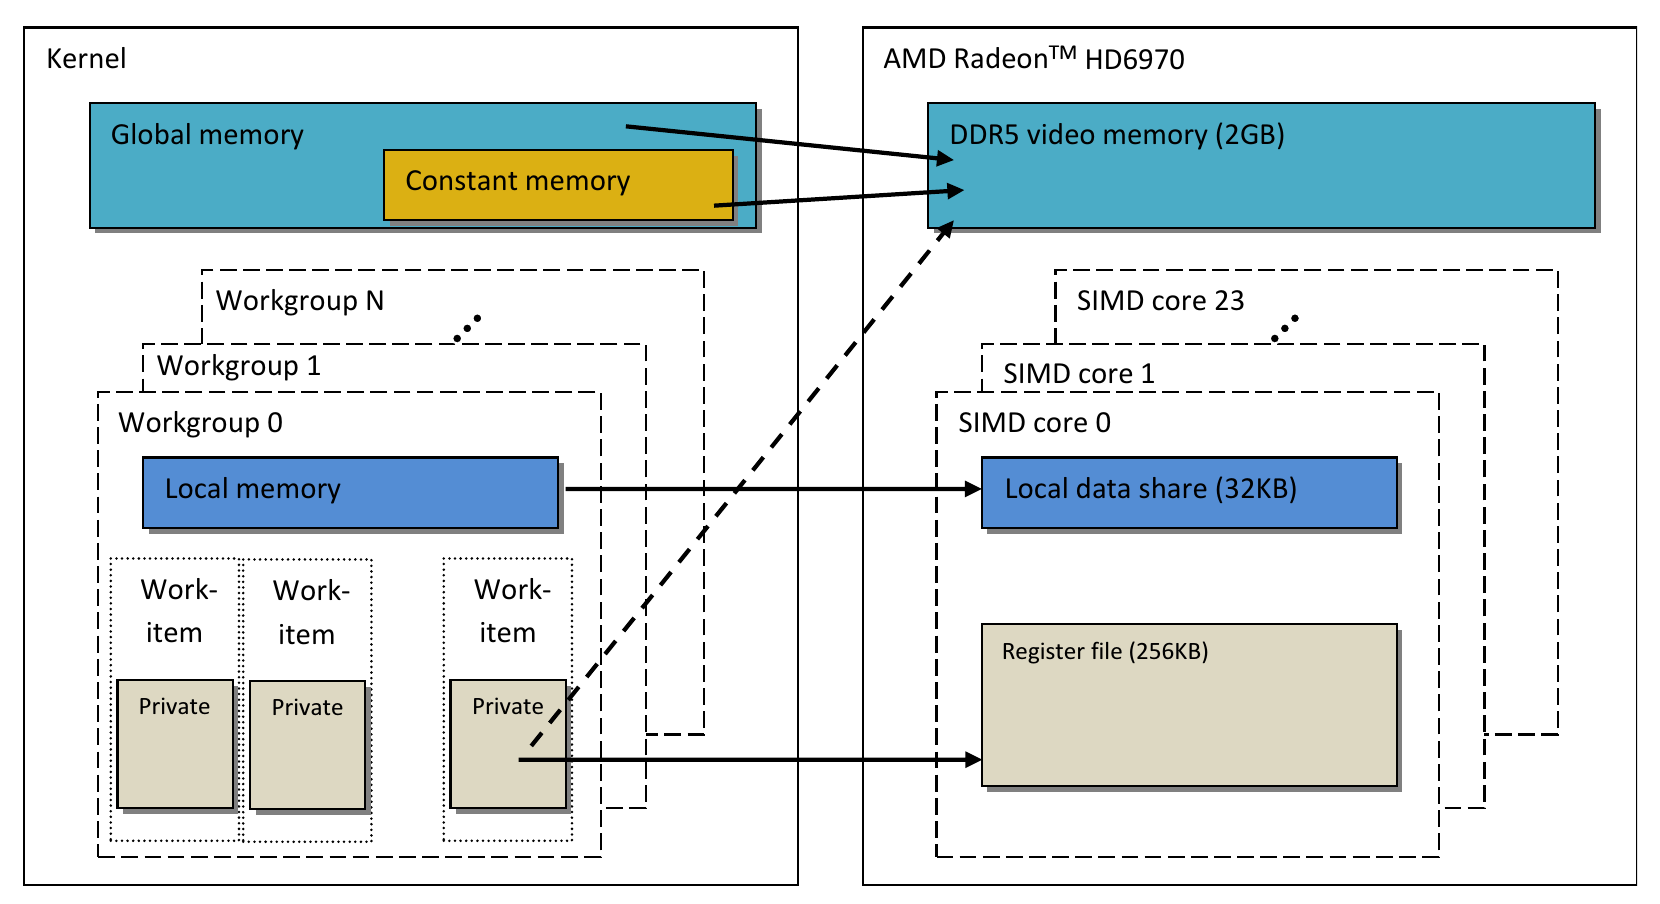

In [41]:
from IPython.display import Image
print "imagenes de Heterogeneous Computing with OpenCL"
Image(filename='Capturas/memory_map.png', width=700)

### Modelo de ejecución en OpenCL

imagenes de Heterogeneous Computing with OpenCL


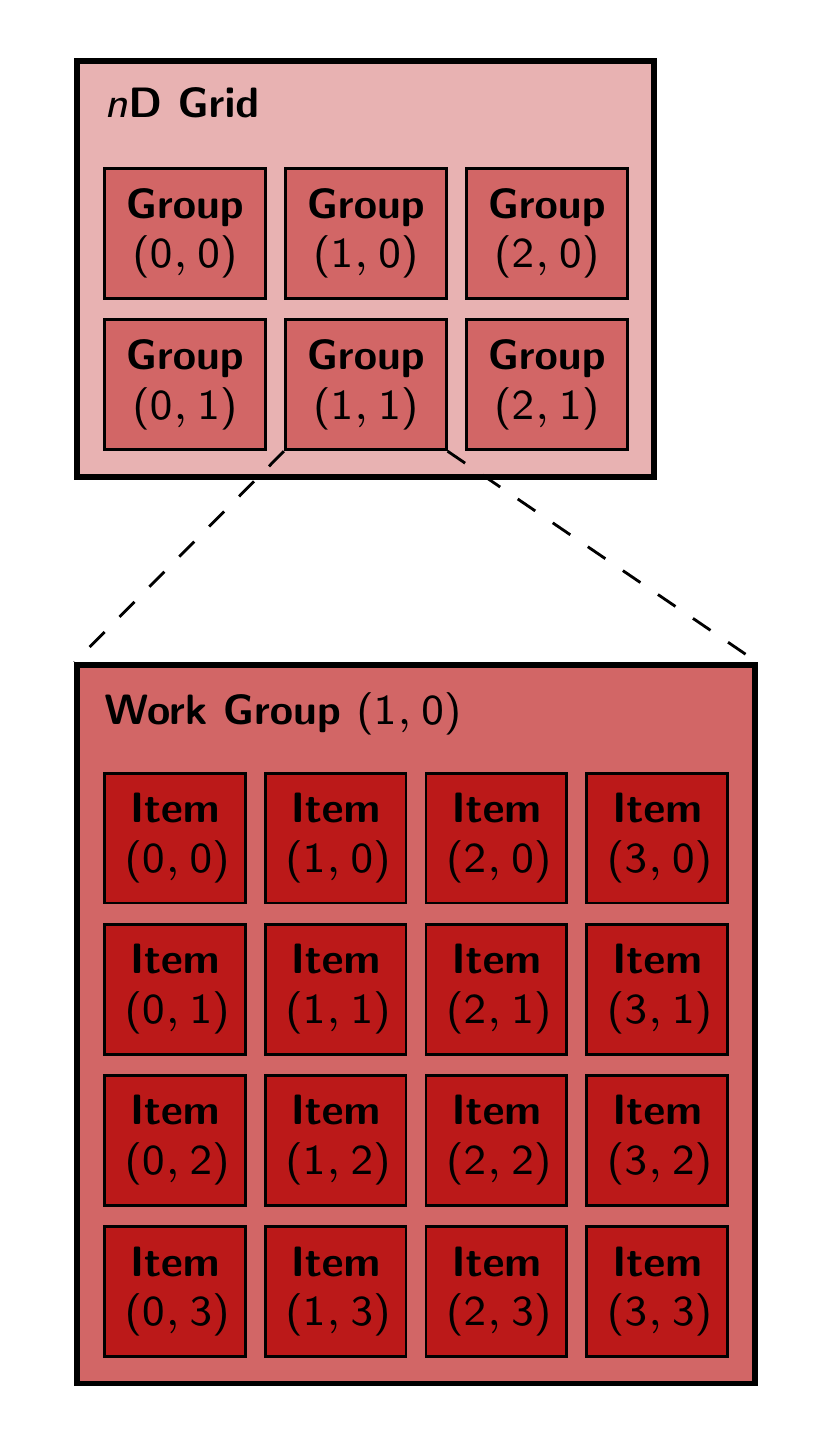

In [42]:
from IPython.display import Image
print "imagenes de Heterogeneous Computing with OpenCL"
Image(filename='Capturas/exe_map.png', width=400)

### Ejemplos de uso

In [24]:
import pyopencl as cl
import numpy as np
import matplotlib.pyplot as plt

### Obteniendo información sobre nuestras plataformas, dispositivos y contextos!

In [25]:
cl.get_cl_header_version() #OpenCL headers

(1, 2)

In [26]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

imagenes de http://mathema.tician.de/software/pyopencl/


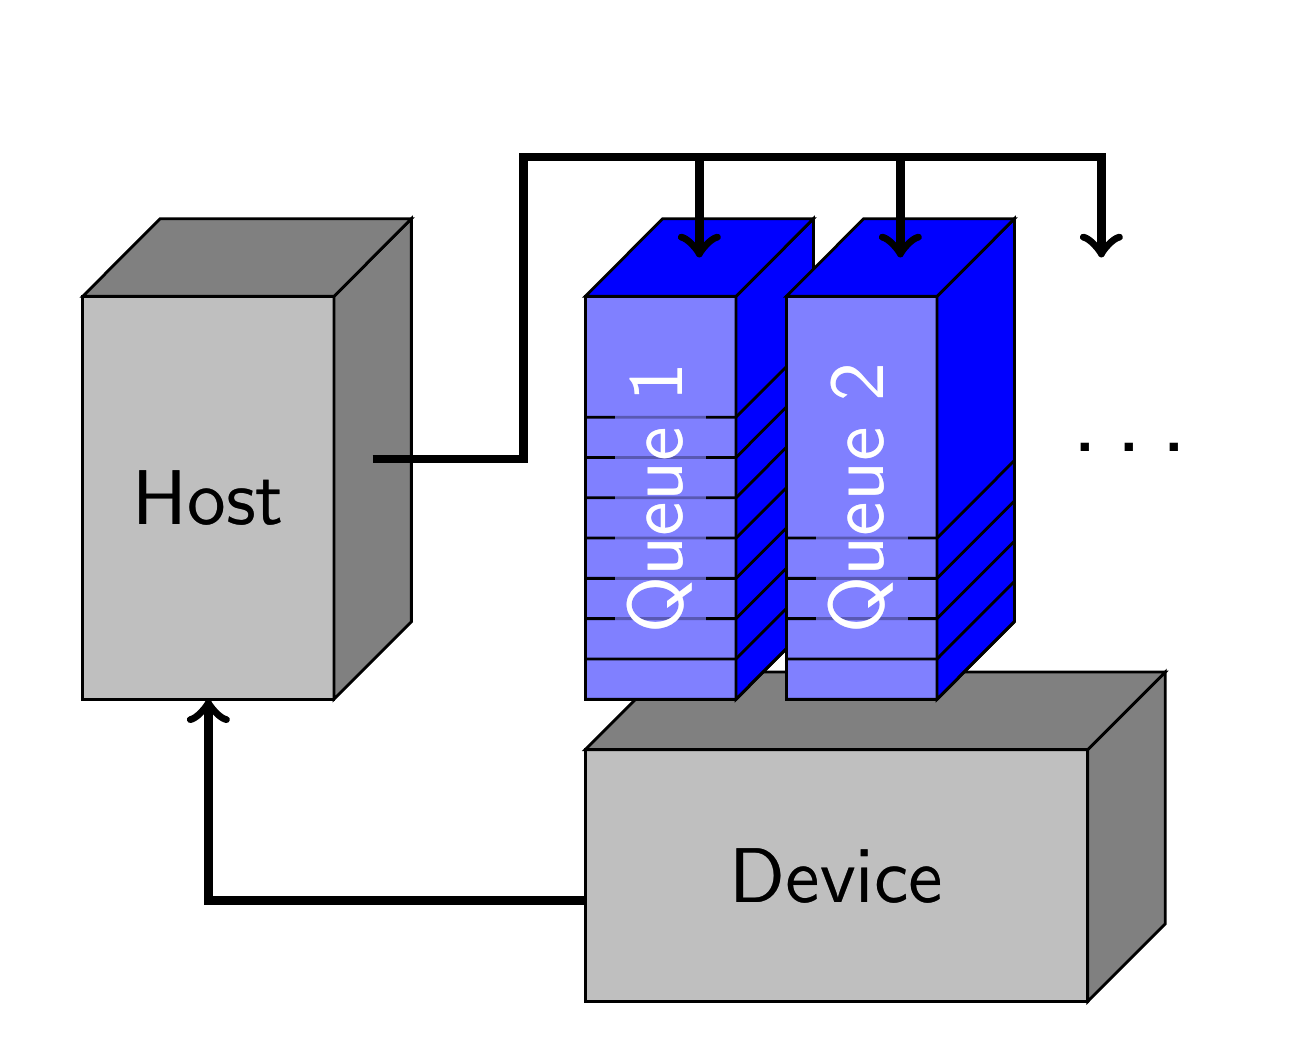

In [46]:
from IPython.display import Image
print "imagenes de http://mathema.tician.de/software/pyopencl/"
Image(filename='Capturas/queue.png', width=300) 

In [27]:
cl.get_platforms()

[<pyopencl.Platform 'NVIDIA CUDA' at 0x56061e06b630>]

In [28]:
cl.get_supported_image_formats(ctx, 1, 2)

[ImageFormat(R, FLOAT),
 ImageFormat(R, HALF_FLOAT),
 ImageFormat(R, UNORM_INT8),
 ImageFormat(R, UNORM_INT16),
 ImageFormat(R, SNORM_INT16),
 ImageFormat(R, SIGNED_INT8),
 ImageFormat(R, SIGNED_INT16),
 ImageFormat(R, SIGNED_INT32),
 ImageFormat(R, UNSIGNED_INT8),
 ImageFormat(R, UNSIGNED_INT16),
 ImageFormat(R, UNSIGNED_INT32),
 ImageFormat(A, FLOAT),
 ImageFormat(A, HALF_FLOAT),
 ImageFormat(A, UNORM_INT8),
 ImageFormat(A, UNORM_INT16),
 ImageFormat(A, SNORM_INT16),
 ImageFormat(A, SIGNED_INT8),
 ImageFormat(A, SIGNED_INT16),
 ImageFormat(A, SIGNED_INT32),
 ImageFormat(A, UNSIGNED_INT8),
 ImageFormat(A, UNSIGNED_INT16),
 ImageFormat(A, UNSIGNED_INT32),
 ImageFormat(RG, FLOAT),
 ImageFormat(RG, HALF_FLOAT),
 ImageFormat(RG, UNORM_INT8),
 ImageFormat(RG, UNORM_INT16),
 ImageFormat(RG, SNORM_INT16),
 ImageFormat(RG, SIGNED_INT8),
 ImageFormat(RG, SIGNED_INT16),
 ImageFormat(RG, SIGNED_INT32),
 ImageFormat(RG, UNSIGNED_INT8),
 ImageFormat(RG, UNSIGNED_INT16),
 ImageFormat(RG, UNSIGNED_I

### Mapa logistico

$$ \qquad x_{n+1} = r x_n (1-x_n)$$

- El crecimiento de tipo exponencial de la población (efecto más visible cuando la población es pequeña).
- La mortalidad adicional que aumenta a medida que crece la población, debido a la competencia de los individuos entre sí para asegurarse el alimento necesario. Esto se traduce matemáticamente por el término cuadrático con un signo negativo.


In [35]:
from IPython.display import IFrame
IFrame('https://upload.wikimedia.org/wikipedia/commons/b/b2/Logistic_map_examples_small.gif',
      width=600, height=350)

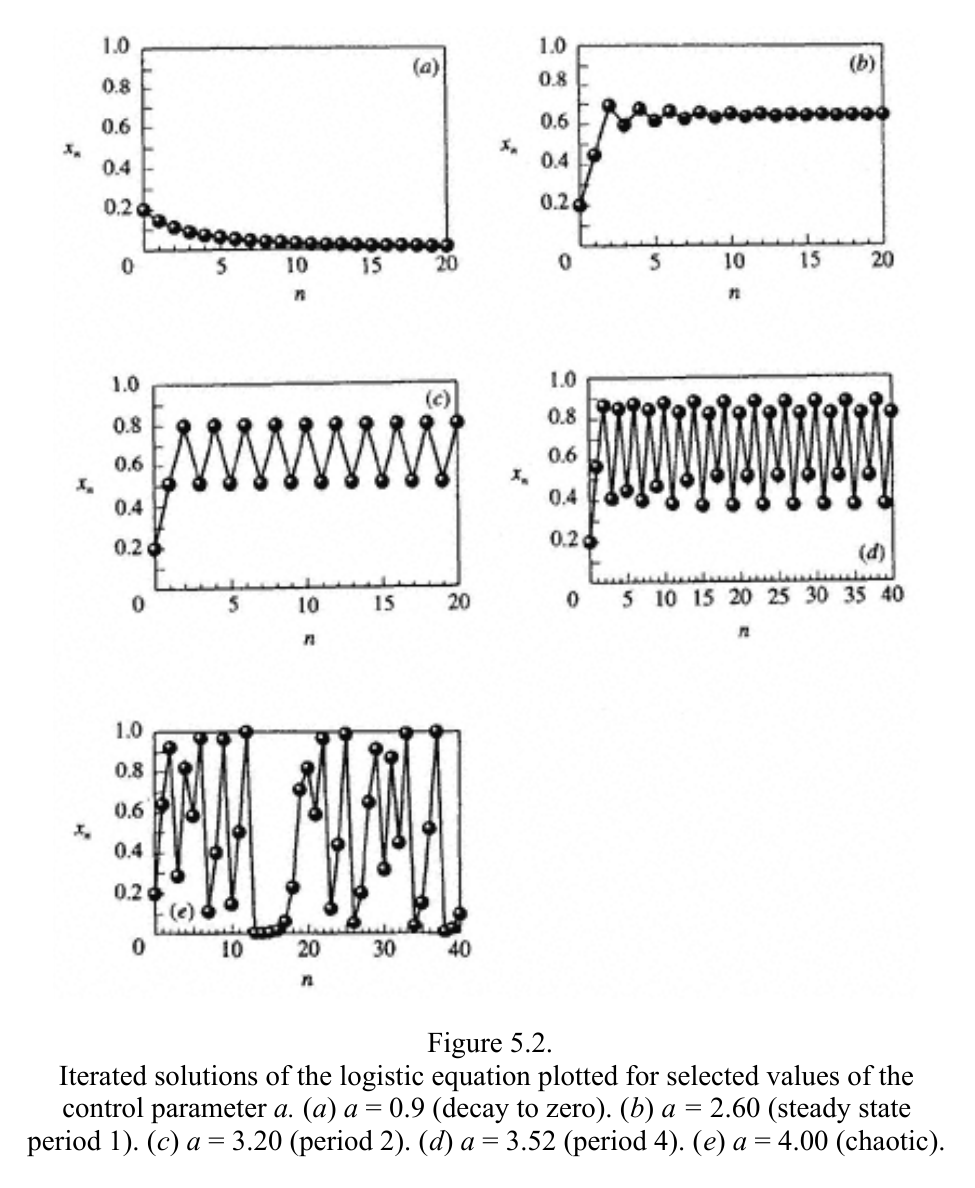

In [10]:
from IPython.display import Image
Image(filename='Capturas/dif_a.png', width=300) 

In [29]:
alpha = 4.0
xd = 0.2

### Escribimos kernel que correra en varios work items

In [34]:
c_code = """
/*kernel for implementing the Verhulst model.
Fractal and Chaos - Chapter 5 - Iterative Feedback Processes and Chaos. */

__kernel void verhulst(global float* alpha, global float* xd, global float* output)
{
    float temp;
    int idx = get_local_id(0)+get_local_size(0)*get_group_id(0);
    temp = xd[0];
    int i;
    for(i=0;i<=idx;i++)
    {
        temp = alpha[0]*temp*(1-temp);
    }
    output[idx] = temp;
}

"""

### Compilamos nuestro kernel

In [35]:
program = cl.Program(ctx, c_code).build()

In [36]:
mf = cl.mem_flags

### Definimos variables del lado del host

In [37]:
alpha = np.float32(alpha)
xd = np.float32(xd)
output = np.zeros(100, np.float32)
#create OpenCL buffers
alpha_buf = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                           hostbuf=alpha)
xd_buf = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                        xd.nbytes, hostbuf=xd)
dest_buf = cl.Buffer(ctx, mf.READ_WRITE, output.nbytes)

### Enviamos kernel a ejecución y guardamos el resultado

In [38]:
program.verhulst(queue, output.shape, (50,), alpha_buf, xd_buf, dest_buf)
#program_name>.<kernel_name>( <command_queue>, <Global_work_size>,
        #       <Local_work_size>, <Parameters_to_kernel.....> )
cl.enqueue_copy(queue, output, dest_buf)


### Graficamos los resultados obtenidos de OpenCL

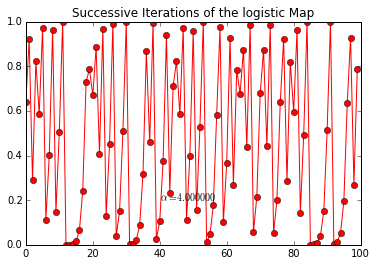

In [39]:
%matplotlib inline
plt.plot(output, 'ro-')
plt.ylim(0, 1)
plt.text(40, 0.2, r'$\alpha = %f$' % (alpha))
plt.title("Successive Iterations of the logistic Map")
plt.show()

## Otro ejemplo ... Blur images

#### Ejemplo sacado de http://polarnick239.github.io/notebooks/opencl/gaussian_blur.html

#### Abrimos a imagen en RGBA para compatibilidad con formatos nativos de opencl

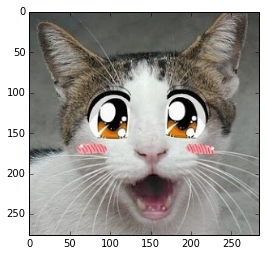

In [40]:
%matplotlib inline
from PIL import Image

im = Image.open('cat.jpg').convert('RGBA')
im = np.array(list(im.getdata())).astype(np.uint8).reshape((276, 285, 4))
plt.imshow(im)

In [41]:
print im

[[[ 70  74  73 255]
  [ 66  70  69 255]
  [ 64  68  67 255]
  ..., 
  [ 68  69  64 255]
  [ 67  68  63 255]
  [ 68  69  64 255]]

 [[ 67  71  70 255]
  [ 66  70  69 255]
  [ 66  70  69 255]
  ..., 
  [ 68  69  64 255]
  [ 69  70  65 255]
  [ 70  71  66 255]]

 [[ 65  69  68 255]
  [ 66  70  69 255]
  [ 68  72  71 255]
  ..., 
  [ 67  68  63 255]
  [ 67  68  63 255]
  [ 67  68  63 255]]

 ..., 
 [[169 169 167 255]
  [175 175 173 255]
  [168 168 166 255]
  ..., 
  [149 151 146 255]
  [151 153 148 255]
  [153 155 150 255]]

 [[173 173 171 255]
  [174 174 172 255]
  [171 171 169 255]
  ..., 
  [153 155 150 255]
  [155 157 152 255]
  [155 157 152 255]]

 [[189 188 186 255]
  [187 186 184 255]
  [172 171 169 255]
  ..., 
  [150 152 147 255]
  [154 156 151 255]
  [157 159 154 255]]]


### Escribimos el kernel ...

In [42]:
blur_code_c = """
__kernel void gauss(__read_only image2d_t img,
                    __write_only image2d_t res,
                    __constant float * gaussian_kernel
                    ) {
    const sampler_t smp = CLK_NORMALIZED_COORDS_FALSE | CLK_FILTER_NEAREST | CLK_ADDRESS_CLAMP_TO_EDGE;
    int2 coord = (int2) (get_global_id(0), get_global_id(1));
    int2 img_size = (int2) (get_image_width(img), get_image_height(img));
    if (any(coord >= img_size)) {
        return;
    }
    
    float4 color = (float4) 0.0;
    int kernel_index = 0;
    for (int dx = -HALF_FILTER_SIZE; dx <= HALF_FILTER_SIZE; ++dx) {
        for (int dy = -HALF_FILTER_SIZE; dy <= HALF_FILTER_SIZE; ++dy, ++kernel_index) {
            color += read_imagef(img, smp, coord + (int2) (dx, dy)) * gaussian_kernel[kernel_index];
        }
    }
    write_imagef(res, coord, color);
}
"""

In [16]:
kernel_size = 11
sigma = 10.0

def calc_gaussian_kernel(kernel_size, sigma):
    assert kernel_size % 2 == 1
    kernel = np.zeros((kernel_size, kernel_size), np.float32)
    for x in range(kernel_size):
        for y in range(kernel_size):
            dx, dy = (x - kernel_size // 2), (y - kernel_size // 2)
            kernel[x, y] = np.exp(-dx**2/(2*sigma**2)-dy**2/(2*sigma**2))
    kernel /= np.sum(kernel)
    return kernel

gaussian_kernel = calc_gaussian_kernel(kernel_size, sigma)
print gaussian_kernel

[[ 0.00709955  0.00742633  0.00769085  0.00788554  0.00800472  0.00804484
   0.00800472  0.00788554  0.00769085  0.00742633  0.00709955]
 [ 0.00742633  0.00776814  0.00804484  0.0082485   0.00837316  0.00841513
   0.00837316  0.0082485   0.00804484  0.00776814  0.00742633]
 [ 0.00769085  0.00804484  0.0083314   0.00854231  0.00867141  0.00871488
   0.00867141  0.00854231  0.0083314   0.00804484  0.00769085]
 [ 0.00788554  0.0082485   0.00854231  0.00875856  0.00889093  0.00893549
   0.00889093  0.00875856  0.00854231  0.0082485   0.00788554]
 [ 0.00800472  0.00837316  0.00867141  0.00889093  0.0090253   0.00907054
   0.0090253   0.00889093  0.00867141  0.00837316  0.00800472]
 [ 0.00804484  0.00841513  0.00871488  0.00893549  0.00907054  0.009116
   0.00907054  0.00893549  0.00871488  0.00841513  0.00804484]
 [ 0.00800472  0.00837316  0.00867141  0.00889093  0.0090253   0.00907054
   0.0090253   0.00889093  0.00867141  0.00837316  0.00800472]
 [ 0.00788554  0.0082485   0.00854231  0.00

### Creamos Queue y Context de ejecución

In [43]:
w, h = im.shape[:2][::-1]

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

### Creamos los buffers de entrada y salida

In [44]:
cl_img_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNORM_INT8)

mf = cl.mem_flags
img_input  = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, cl_img_format, (w, h), hostbuf=im)
img_output = cl.Image(ctx, mf.WRITE_ONLY, cl_img_format, (w, h))
buf_kernel = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=gaussian_kernel)

### Compilamos el kernel

In [45]:
options = ['-D FILTER_SIZE={}'.format(kernel_size),
           '-D HALF_FILTER_SIZE={}'.format(kernel_size//2)]

program = cl.Program(ctx, blur_code_c).build(options)

### Enviamos a la Queue los datos de ejecución

In [46]:
def run(program, queue, img_input, img_output, buf_kernel):
    group_w, group_h = 16, 16
    launch = program.gauss(queue, (288, 288), (group_w, group_h),
                            img_input, img_output, buf_kernel)
    launch.wait()

In [47]:
%timeit run(program, queue, img_input, img_output, buf_kernel)

The slowest run took 10.27 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 289 µs per loop


### Copiamos los resultados de la Queue al Host

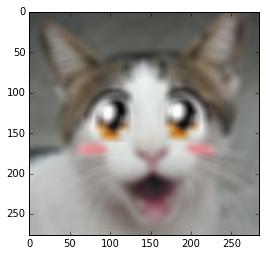

In [48]:
result_img = np.zeros((h, w, 4), np.uint8)
cl.enqueue_copy(queue, result_img, img_output, origin=(0, 0, 0), region=(w, h, 1)).wait()
plt.imshow(result_img)

In [49]:
import cv2

%timeit cv2.GaussianBlur(im, (kernel_size, kernel_size), sigma)


1000 loops, best of 3: 1.14 ms per loop
